# Decision Trees
Let's start with a large dataset and find out how we can use decision trees when our data size is large-sh. We will use the kaggle dataset that attempts to classify plankton. We will use some example code to get us started from the tutorial here:
http://www.kaggle.com/c/datasciencebowl/details/tutorial

*For questions on this notebook, please contact Professor Eric Larson at eclarson@smu.edu*

In [3]:
# load another dataset (large) and train using various methods of gradient (and mini-batch)
import glob
import os

# change this to point to the dataset on your machine/cluster!!
directory_of_dataset = "../Data/datasciencebowl/"

# get the classnames from the directory structure
#directory_names = list(set(glob.glob(os.path.join(directory_of_dataset,"kaggle_plank", "*"))
# ).difference(set(glob.glob(os.path.join(directory_of_dataset,"kaggle_plank","*.*")))))

directory_names = list(set(glob.glob(os.path.join(directory_of_dataset, "train","*"))
 ).difference(set(glob.glob(os.path.join(directory_of_dataset,"train","*.*")))))
                           
print ('number of classes:', len(directory_names))

number of classes: 121


In [4]:
# Rescale the images and create the combined metrics and training labels
from skimage.transform import resize
from skimage.io import imread
import numpy as np

#get the total training images
numberofImages = 0
for folder in directory_names:
    for fileNameDir in os.walk(folder):   
        for fileName in fileNameDir[2]:
             # Only read in the images
            if fileName[-4:] != ".jpg":
                continue
            numberofImages += 1

# We'll rescale the images to be 40x40
maxPixel = 25
imageSize = maxPixel * maxPixel
num_rows = numberofImages # one row for each image in the training dataset
num_features = imageSize # for our ratio

# X is the feature vector with one row of features per image
# consisting of the pixel values and our metric
X = np.zeros((num_rows, num_features), dtype=float)
# y is the numeric class label 
y = np.zeros((num_rows))

files = []
# Generate training data
i = 0    
label = 0
# List of string of class names
namesClasses = list()

print ("Reading images")
# Navigate through the list of directories
for folder in directory_names:
    # Append the string class name for each class
    currentClass = folder.split(os.pathsep)[-1]
    namesClasses.append(currentClass)
    for fileNameDir in os.walk(folder):   
        for fileName in fileNameDir[2]:
            # Only read in the images
            if fileName[-4:] != ".jpg":
                continue
            
            # Read in the images and create the features
            nameFileImage = "{0}{1}{2}".format(fileNameDir[0], os.sep, fileName)            
            image = imread(nameFileImage, as_grey=True)
            files.append(nameFileImage)
            #axisratio = getMinorMajorRatio(image)
            image = resize(image, (maxPixel, maxPixel))
            
            # Store the rescaled image pixels and the axis ratio
            X[i, 0:imageSize] = np.reshape(image, (1, imageSize))
            #X[i, imageSize] = axisratio
            
            # Store the classlabel
            y[i] = label
            i += 1
            # report progress for each 5% done  
            report = [int((j+1)*num_rows/20.) for j in range(20)]
            if i in report: print (np.ceil(i *100.0 / num_rows), "% done")
    label += 1

Reading images


C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:48: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


5.0 % done
10.0 % done
15.0 % done
20.0 % done
25.0 % done
30.0 % done
35.0 % done
40.0 % done
45.0 % done
50.0 % done
55.0 % done
60.0 % done
65.0 % done
70.0 % done
75.0 % done
80.0 % done
85.0 % done
90.0 % done
95.0 % done
100.0 % done


In [5]:
# here is where the online tutorial code stops and my code starts
print ('num features:', X.shape)
print ('num labels:', y.shape)

num features: (30336, 625)
num labels: (30336,)


In [6]:
# now divide the data into test and train using scikit learn built-ins
from sklearn.model_selection import StratifiedShuffleSplit 

cv = StratifiedShuffleSplit(n_splits=1,train_size=0.5)
print (cv)

StratifiedShuffleSplit(n_splits=1, random_state=None, test_size=None,
            train_size=0.5)


In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics as mt

dt_clf = DecisionTreeClassifier()

# now get the training and testing
for train, test in cv.split(X,y):
    print ('Training Once:')
    # train the decision tree algorithm
    %time dt_clf.fit(X[train],y[train])
    yhat = dt_clf.predict(X[test])
    print ('accuracy:', mt.accuracy_score(y[test],yhat))


Training Once:
Wall time: 26.9 s
accuracy: 0.2529008438818565


In [8]:
# from the tutorial: http://www.kaggle.com/c/datasciencebowl/details/tutorial 
def multiclass_log_loss(y_true, y_pred, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    https://www.kaggle.com/wiki/MultiClassLogLoss

    Parameters
    ----------
    y_true : array, shape = [n_samples]
            true class, integers in [0, n_classes - 1)
    y_pred : array, shape = [n_samples, n_classes]

    Returns
    -------
    loss : float
    """
    predictions = np.clip(y_pred, eps, 1 - eps)

    # normalize row sums to 1
    predictions /= predictions.sum(axis=1)[:, np.newaxis]

    actual = np.zeros(y_pred.shape)
    n_samples = actual.shape[0]
    actual[np.arange(n_samples), y_true.astype(int)] = 1
    vectsum = np.sum(actual * np.log(predictions))
    loss = -1.0 / n_samples * vectsum
    return loss

In [9]:
yhat = dt_clf.predict(X[test])
class_probabilities = dt_clf.predict_proba(X[test])
print ('Accuracy:', mt.accuracy_score(y[test],yhat))
print ('Log Loss:', multiclass_log_loss(y[test], class_probabilities))

Accuracy: 0.2529008438818565
Log Loss: 25.803890697991246


In [10]:
from sklearn.decomposition import PCA

n_components = 50
pca = PCA(n_components=n_components, svd_solver='randomized')

for train, test in cv.split(X,y):
    print ('Training Once:')
    
    # transform the data using pca
    pca.fit(X[train])
    X_train = pca.transform(X[train])
    X_test = pca.transform(X[test])
    
    # train the decision tree algorithm
    dt_clf.fit(X_train,y[train])
    yhat = dt_clf.predict(X_test)
    class_probabilities = dt_clf.predict_proba(X_test)
    
    print ('Accuracy:', mt.accuracy_score(y[test],yhat))
    print ('Log Loss:', multiclass_log_loss(y[test], class_probabilities))

Training Once:
Accuracy: 0.3026766877637131
Log Loss: 24.08469395628781


In [11]:
log_losses = []
accuracies = []
params = []

from matplotlib import pyplot as plt
%matplotlib inline

Training Once:
Accuracy: 0.2219145569620253
Log Loss: 3.607446106603494


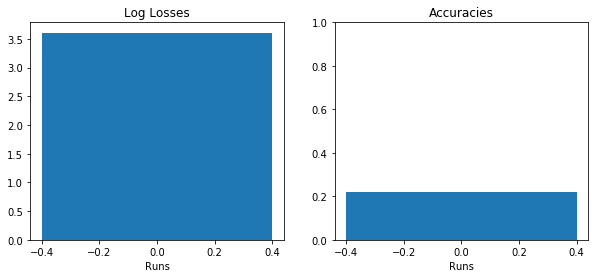

In [12]:
# how to make it generalize a bit better? 

# defaults
dt_clf = DecisionTreeClassifier(criterion='gini', max_depth=None, 
                                min_samples_split=2, min_samples_leaf=1, 
                                max_features=None,
                                max_leaf_nodes=None)

# overwrite with prepruning methods
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=5, 
                                min_samples_split=1000, min_samples_leaf=1, 
                                max_leaf_nodes=None)

for train, test in cv.split(X,y):
    print ('Training Once:')
    
    # transform the data using pca
    pca.fit(X[train])
    X_train = pca.transform(X[train])
    X_test = pca.transform(X[test])
    
    # train the decision tree algorithm
    dt_clf.fit(X_train,y[train])
    yhat = dt_clf.predict(X_test)
    class_probabilities = dt_clf.predict_proba(X_test)
    
    # get accuracy and log loss of this training
    acc = mt.accuracy_score(y[test],yhat)
    ll = multiclass_log_loss(y[test], class_probabilities)
    print ('Accuracy:', acc)
    print ('Log Loss:', ll)
    
    # save accuracy, log loss, and params of run
    log_losses.append(ll)
    accuracies.append(acc)
    params.append(dt_clf.get_params())
    
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar(range(len(log_losses)),log_losses)
plt.title('Log Losses')
plt.xlabel('Runs')

plt.subplot(1,2,2)
plt.bar(range(len(accuracies)),accuracies)
plt.title('Accuracies')
plt.xlabel('Runs')
plt.ylim([0,1])

plt.show()

In [13]:
# a telling example for log loss minimization
class_probabilities = np.ones((len(y[test]),len(np.unique(y))))
print ('Log Loss of "Chance":', multiclass_log_loss(y[test], class_probabilities))

Log Loss of "Chance": 4.795790545596764


# Feature Importances
The feature importances can be calculated using the Mean decrease in the gini index. Essentially, every time a feature is tested for splitting, the decrease in the gini (or entropy) is saved. The importance of the feature can then be approximated by taking the mean decrease in the gini for all the nodes where the feature is tested (usually the feature is tested at every node):
$$ Imp_{A} = \frac{1}{|T|}\sum_{t \in T} gini_A(p_t) - gini_A(t) $$
where $|T|$ is the total number of nodes in the tree, $T$ is the set of all nodes, $gini_A(t)$ is the gini for the $A^{th}$ attribute at node $t$, and $gini_A(p_t)$ is the gini for the $A^{th}$ attribute at the **parent** node for $t$.

In this way, we have the mean decrease in the gini for attribute $A$. We can make a vector of these importance for all attributes in the dataset: $[Imp_1, Imp_2, ... Imp_{A_{tot}}]$.

`scikit-learn` computes this value for you and it is stored inside the tree object as `dt_clf.feature_importances_`. For the current dataset, the images are feature vectors of size 25x25=625 pixels. Therefore we can look at the importances as a bar graph with 625 instances or we can reshape the instances to see the importances as a 25x25 image. Both are done below.

Training Once:
accuracy: 0.26410864978902954


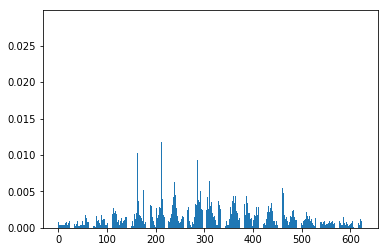

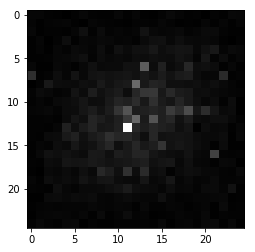

In [14]:
dt_clf = DecisionTreeClassifier()

# now get the training and testing
for train, test in cv.split(X,y):
    print ('Training Once:')
    # train the decision tree algorithm
    dt_clf.fit(X[train],y[train])
    yhat = dt_clf.predict(X[test])
    print ('accuracy:', mt.accuracy_score(y[test],yhat))
    
# get the importances
imp = dt_clf.feature_importances_

#plot the importances as bar chart
plt.bar(range(len(imp)),imp)

# reshape the importances to be size of the original images
# and show it
imp_as_image = np.reshape(imp,(25,25))
plt.figure()
plt.imshow((imp_as_image), cmap=plt.cm.gray)

plt.show()

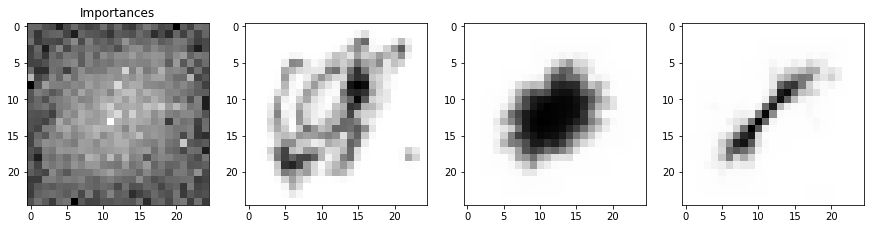

In [17]:
from random import randint
# look at importances on a log scale
plt.figure(figsize=(15,20))
plt.subplot(1,4,1)
plt.imshow(np.log(imp_as_image), cmap=plt.cm.gray)
plt.title('Importances')

for i in range(2,5):
    plt.subplot(1,4,i)
    plt.imshow(np.reshape(X[randint(0,len(X))],(25,25)),cmap=plt.cm.gray)

plt.show()

# Other Methods for Making the Tree Generalize
Everything that sciki-learn implements is used for pre-pruning the tree: that is, we stop making nodes during the decision tree induction process. However, there are other methods that post-prune the tree where:
- We build a tree completely
- Then select a group a leaf nodes that belong to a split 
- And, finally decide if we should prune the split (making the parent node a leaf node)
- Then repeat until some criteria is met

This is called post pruning and can be a good method for creating a decision tree that is not "overlearned". Let's look at these in lecture now.